# Notebook 2 : Xarray and CuPy (Real Dataset)


Negin Sobhani and Deepak Cherian  
Computational & Information Systems Lab (CISL)  
negins@ucar.edu, dcherian@ucar.edu  

------------

## Introduction 

In the previous tutorial, we introduced the powerful combination of Xarray and CuPy for handling multi-dimensional datasets and leveraging GPU acceleration to significantly improve performance. We explored high-level Xarray functions such as groupby, rolling mean, and weighted mean, and compared their execution times with traditional NumPy-based implementations. In this tutorial, we will dive deeper into the subject with a hands-on approach, utilizing a real-world dataset. This will enable us to better understand the practical applications of Xarray and CuPy and how they can be efficiently utilized for real-life data analysis tasks.

In [1]:
import numpy as np 
import dask.array as da
import xarray as xr

In [2]:
import cupy as cp
import cupy_xarray  # Adds .cupy to Xarray objects

In [3]:
import os
import glob

var = 'TREFHT'

# find all LENS files for 1 ensemble
data_dir = os.path.join('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/month_1/', var)
files = glob.glob(os.path.join(data_dir, 'b.e21.BSSP370cmip6.f09_g17.LE2-1301.0*'))

print("All files: [", len(files), "files]")

All files: [ 90 files]


#### Reading one file

In [4]:
ds = xr.open_dataset(
    files[0],
    # concatenate along this dimension
    # these are netCDF4 files, use the netcdf4-python package to read them
    engine="netcdf4",
    chunks={'lat':50}
)
tref=ds.TREFHT
tref

<xarray.DataArray 'TREFHT' (time: 120, lat: 192, lon: 288)>
dask.array<open_dataset-a11d2bd48a4ce236d4905595a0eb57b8TREFHT, shape=(120, 192, 288), dtype=float32, chunksize=(120, 50, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2075-02-01 00:00:00 ... 2085-01-01 00:00:00
Attributes:
    units:         K
    long_name:     Reference height temperature
    cell_methods:  time: mean

We can convert the underlying numpy array to cupy array using `cupy.as_cupy()`. 

In [9]:
tref_cp = tref.as_cupy()

We can use `dask.visualize` to generate visual representations of the computation graph for this array. 



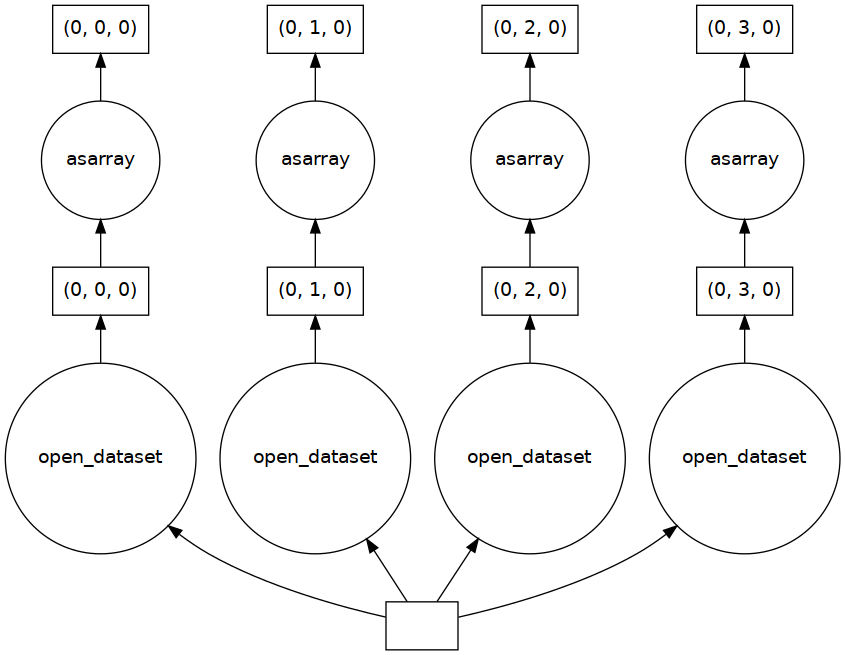

In [10]:
# -- Deepak: It will be good to explain what is happening here & add Dask graph
import dask
dask.visualize(tref_cp)

The visualization graph shows the steps for getting the cupy array. First step is open_dataset and next we convert the cupy array to numpy array. 

In [12]:
# -- look at accessors.py for as.array and explain what happens here.
tref_cp.data.dask

HighLevelGraph with 3 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x2b902d04dd30>
 0. original-open_dataset-a11d2bd48a4ce236d4905595a0eb57b8TREFHT-9a87531b6dc225dba90b6d11b6fba07d
 1. open_dataset-a11d2bd48a4ce236d4905595a0eb57b8TREFHT-9a87531b6dc225dba90b6d11b6fba07d
 2. asarray-228e9a7989415e37e53e3dc614458d26

In [13]:
# add something on how they can check the type of the tref vs. tref_cp
tref.cupy.is_cupy

False

In [14]:
tref_cp.cupy.is_cupy

True

In [15]:
# -- some monthly or climatology average. 
tref

<xarray.DataArray 'TREFHT' (time: 120, lat: 192, lon: 288)>
dask.array<open_dataset-a11d2bd48a4ce236d4905595a0eb57b8TREFHT, shape=(120, 192, 288), dtype=float32, chunksize=(120, 50, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2075-02-01 00:00:00 ... 2085-01-01 00:00:00
Attributes:
    units:         K
    long_name:     Reference height temperature
    cell_methods:  time: mean

## Reading Multiple netcdf files

In [16]:
ds = xr.open_mfdataset(
    sorted(files),
    # concatenate along this dimension
    concat_dim='ensemble_member',
    # concatenate files in the order provided
    combine="nested",
    # parallelize the reading of individual files using dask
    # This means the returned arrays will be dask arrays
    parallel=True,
    # these are netCDF4 files, use the netcdf4-python package to read them
    engine="netcdf4",

)
ds

<xarray.Dataset>
Dimensions:       (lat: 192, zlon: 1, lon: 288, lev: 32, ilev: 33, time: 1032,
                   ensemble_member: 90, nbnd: 2)
Coordinates:
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * zlon          (zlon) float64 0.0
  * lon           (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time          (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Dimensions without coordinates: ensemble_member, nbnd
Data variables: (12/27)
    zlon_bnds     (ensemble_member, zlon, nbnd) float64 dask.array<chunksize=(1, 1, 2), meta=np.ndarray>
    gw            (ensemble_member, lat) float64 dask.array<chunksize=(1, 192), meta=np.ndarray>
    hyam          (ensemble_member, lev) float64 dask.array<chunksize=(1, 32), meta=np.ndarray>
    hybm          (ensemble_member, lev) float64 dask.array<chunksize=(1, 32), meta=np.ndarray>
    P0            (ensemble_member) float64 1e+05 1e+05 1e+05 ... 1e+05 1e+05
    hyai          (ensemble_member, ilev) float64 dask.array<chunksize=(1, 33), meta=np.ndarray>
    ...            ...
    n2ovmr        (ensemble_member, time) float64 dask.array<chunksize=(1, 1032), meta=np.ndarray>
    f11vmr        (ensemble_member, time) float64 dask.array<chunksize=(1, 1032), meta=np.ndarray>
    f12vmr        (ensemble_member, time) float64 dask.array<chunksize=(1, 1032), meta=np.ndarray>
    sol_tsi       (ensemble_member, time) float64 dask.array<chunksize=(1, 1032), meta=np.ndarray>
    nsteph        (ensemble_member, time) float64 dask.array<chunksize=(1, 1032), meta=np.ndarray>
    TREFHT        (ensemble_member, time, lat, lon) float32 dask.array<chunksize=(1, 1032, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              b.e21.BSSP370cmip6.f09_g17.LE2-1301.001
    logname:           sunseon
    host:              mom2
    initial_file:      b.e21.BHISTcmip6.f09_g17.LE2-1301.001.cam.i.2015-01-01...
    topography_file:   /mnt/lustre/share/CESM/cesm_input/atm/cam/topo/fv_0.9x...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1

In [17]:
tref_cp = tref.as_cupy()

### Groupby
The groupby function is used to group data based on one or more dimensions. Here, we'll group our data by the 'time' dimension using both CuPy and NumPy:

Now, let's calculate climatology average: 

In [18]:
%%time
climo_tref_np = tref.groupby('time.month').mean('time').compute()

CPU times: user 351 ms, sys: 34.6 ms, total: 386 ms
Wall time: 414 ms


We can do similar calculations using cupy. 

In [20]:
%%time
climo_tref_cp = tref_cp.groupby('time.month').mean('time').compute()

CPU times: user 455 ms, sys: 30.5 ms, total: 486 ms
Wall time: 758 ms


In [21]:
dask.visualize(climo_tref_cp, rankdir='LR')

In [25]:
import time
start_time_np = time.time()

grouped_data_np = tref.groupby('time.month').mean('time')

end_time_np = time.time()
time_np = end_time_np - start_time_np

start_time_cp = time.time()

grouped_data_cp = tref_cp.groupby('time.month').mean('time')

end_time_cp = time.time()
time_cp = end_time_cp - start_time_cp

print("GroupBy with Xarray DataArrays using CuPy provides a", round(time_np / time_cp,2), "x speedup over NumPy.\n")

GroupBy with Xarray DataArrays using CuPy provides a 1.09 x speedup over NumPy.



## Advanced workflows and automatic parallelization using apply_ufunc

`xr.apply_ufunc()` can automate embarrassingly parallel “map” type operations where a function written for processing NumPy arrays, but we want to apply it on our Xarray DataArray.

xr.apply_ufunc() give users capability to run custom-written functions such as parameter calculations in a parallel way. See the Xarray tutorial material on apply_ufunc for more.

In the example below, we calculate the saturation vapor pressure by using apply_ufunc() to apply this function to our Dask Array chunk by chunk.

In [26]:
import numpy as np
# return saturation vapor pressure
# using Clausius-Clapeyron equation
def sat_p(t):
    return 0.611*cp.exp(17.67*(t-273.15)*((t-29.65)**(-1)))

In [27]:
%%time
es=xr.apply_ufunc(sat_p,tref,dask="parallelized",output_dtypes=[float])
es


CPU times: user 4.06 ms, sys: 3 µs, total: 4.06 ms
Wall time: 4.09 ms


<xarray.DataArray 'TREFHT' (time: 120, lat: 192, lon: 288)>
dask.array<transpose, shape=(120, 192, 288), dtype=float64, chunksize=(120, 50, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2075-02-01 00:00:00 ... 2085-01-01 00:00:00

In [28]:
%%time 
es_cp=xr.apply_ufunc(sat_p,tref_cp,dask="parallelized",output_dtypes=[float])
es_cp.cupy.is_cupy

CPU times: user 1.25 ms, sys: 34 µs, total: 1.28 ms
Wall time: 1.29 ms


True

### Add Plotting (Transfer to CPUs)